# Time-varying wage offer distribution in the McCall (1970) model

Relative to the benchmark McCall (1970) model, there is an exogenously specified two-state Markov chain $x_{t}$ with
transition matrix $\mathbf{P}$ that determines the distribution of offers in
period $t$. In particular, when $x_{t}=e_{i}$, $i=1,2$, then $w_{t}$ is
drawn from distribution $Beta\left( \alpha _{w}^{i},\beta _{w}^{i}\right) $.
Verify that the optimal policy takes the form of a state-dependent
reservation wage $\bar{w}_{i}$. Use offer distribution parameters $\alpha
_{w}^{1}=\beta _{w}^{1}=0.5$ and $\alpha _{w}^{2}=\alpha _{w}^{2}=2$, and
transition matrix

\begin{equation*}
\mathbf{P}=\left(
\begin{array}{cc}
\phi  & 1-\phi  \\
1-\phi  & \phi
\end{array}%
\right)
\end{equation*}

with $\phi =0.8$.

The recursive problem is conceptually analogous to the baseline model, with
the added feature that now, the expectation over the next-period wage offer
distribution is a mixture across two alternative offer distributions\ (with
probabilities $\phi $ and $1-\phi $):

\begin{equation*}
E\left[ V\left( w^{\prime }\right) |x_{t}=e_{i}\right] =\sum_{j=1}^{2}%
\mathbf{P}_{ij}\int_{0}^{B}V\left( w^{\prime }\right) dF\left( w^{\prime
}|e_{j}\right) ,
\end{equation*}

where $F\left( w^{\prime }|e_{j}\right) $ is the cdf of the $Beta\left(
\alpha _{w}^{j},\beta _{w}^{j}\right) $ distribution. Because this mixture
depends on the current realization of $x_{t}$, the state vector for a worker
who received a wage offer $w_{t}$ is $\left( w_{t},x_{t}\right) $.  We thus
have the Bellman equation

\begin{equation*}
V\left( w,e_{i}\right) =\max_{\left\{ \text{accept, reject}\right\} }\left\{
\frac{w}{1-\beta },c+\beta \sum_{j=1}^{2}\mathbf{P}_{ij}\int_{0}^{B}V\left(
w^{\prime },e_{j}\right) dF\left( w^{\prime }|e_{j}\right) \right\} .
\end{equation*}

A value function iteration algorithm works in the same way as in the case
without $x_{t}$.


## Numerical implementation

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook - may want to uncomment the next line for older versions of Jupyter
# %matplotlib inline

# import packages
import numpy as np
from scipy import stats

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


Quadrature rule for integrating across wage offer distribution.

In [3]:
# simple_quadrature constructs an equidistant grid quadrature rule on interval r, either from density f or cdf F
# the functions f or F need to be provided as arguments, param is the parameter vector (can be empty)
def simple_quadrature(r=[0,1],I=10,f="",F="",param=""):
    if F:
        # construct weights from F
        nodes = np.linspace(r[0],r[1],I)
        weights = np.linspace(r[0],r[1],I)
        weights[1:-1] = F((nodes[2:]+nodes[1:-1])/2,param) - F((nodes[1:-1]+nodes[:-2])/2,param)
        weights[0] = F((nodes[1]+nodes[0])/2,param) - F(nodes[0],param)
        weights[-1] = F(nodes[-1],param) - F((nodes[-1]+nodes[-2])/2,param)
    elif f:
        nodes = np.linspace(r[0],r[1],I)
        weights = f(nodes,param)
        # nodes at boundaries receive half weight
        weights[0] /= 2
        weights[-1] /= 2
        # renormalize weights to sum up to one
        weights = weights/sum(weights)
    else:
        print('Neither pdf nor cdf were defined.')
            
    return nodes, weights

Value function iteration for the model with state-dependent distribution.

In [4]:
def mccall_value_function_iteration_state_dependent(model):
    I,c,beta,B,P = model["I"],model["c"],model["beta"],model["B"],model["P"]
    N = P.shape[1]
    Vnew = np.asmatrix(np.ones([I,N]))
    Vold = np.asmatrix(np.zeros([I,N]))
    w_nodes_mat = np.asmatrix(np.zeros([I,N]))
    weights_mat = np.asmatrix(np.zeros([I,N]))
    for i in range(N):
        w_nodes,weights = simple_quadrature(r=[0,B],I = model["I"],F=model["F_cdf"],param=model["F_param"][i])
        w_nodes_mat[:,i] = np.asmatrix(w_nodes).transpose()
        weights_mat[:,i] = np.asmatrix(weights).transpose()
    eps = 10**(-10)
    iters = 0
    while (abs(Vold-Vnew)).max() > eps:
        Vold = Vnew
        Vnew = np.maximum(w_nodes_mat/(1-beta),c + beta*sum(np.multiply(Vnew,weights_mat))*P)
        iters += 1
    # derive reservation wage from Q = wbar/(1-beta)
    wbar = (1-model["beta"])*Vnew[0,:]
    return Vnew,wbar,w_nodes_mat,iters

In [5]:
# F is beta cdf on [0,1], with parameters [alpha,beta]
def F_beta(w,param):
    alph = param[0]
    bet = param[1]
    return stats.beta.cdf(w,alph,bet)

# define model parameters, I is the number of random draws of w every period
model = {"beta":0.96, "B": 1, "c": 0.4, "F_cdf": F_beta, "I" : 1000, "F_param": [[0.5,0.5],[2,2]]}
model["phi"] = 0.8
model["P"] = np.asmatrix([[model["phi"],1-model["phi"]],[1-model["phi"],model["phi"]]])

# baseline model without state dependence
model_baseline = model.copy()
model_baseline["F_param"] = [[0.5,0.5]];
model_baseline["P"] = np.asmatrix([1])

# model with iid transition matrix
model_iid = model.copy()
model_iid["phi"] = 0.5
model_iid["P"] = np.asmatrix([[model_iid["phi"],1-model_iid["phi"]],[1-model_iid["phi"],model_iid["phi"]]])

# solve for the value function using value function iteration
V,wbar,w_nodes,i = mccall_value_function_iteration_state_dependent(model)
V_base,wbar_base,w_nodes_base,i_base = mccall_value_function_iteration_state_dependent(model_baseline)
V_iid,wbar_iid,w_nodes_iid,i_iid = mccall_value_function_iteration_state_dependent(model_iid)

print(f'Reservation wages in state-dependent model: {wbar[0,0]:.5}, {wbar[0,1]:.5}. Reached in {i} iterations.')
print(f'Reservation wage in baseline model: {wbar_base[0,0]:.5}. Reached in {i_base} iterations.')
print(f'Reservation wages in iid model: {wbar_iid[0,0]:.5}, {wbar_iid[0,1]:.5}. Reached in {i_iid} iterations.')


Reservation wages in state-dependent model: 0.83639, 0.80647. Reached in 105 iterations.
Reservation wage in baseline model: 0.87211. Reached in 80 iterations.
Reservation wages in iid model: 0.82757, 0.82757. Reached in 101 iterations.


Plotting the value functions in the baseline and modified model.


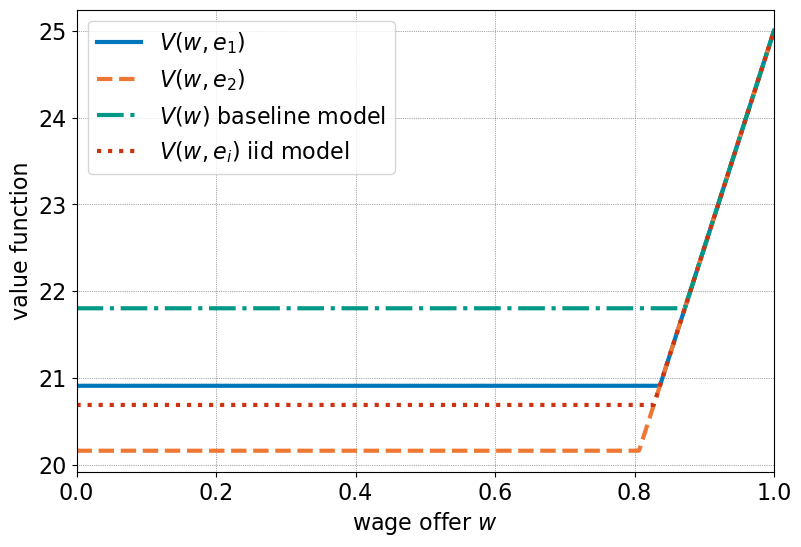

In [6]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,1], 'ylim': [0,0],
         'xlabel': 'wage offer $w$', 'ylabel': 'value function',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

print('Plotting the value functions in the baseline and modified model.')
fig,ax = ec.GenerateTSPlot(param)

ax.plot(w_nodes[:,0],V[:,0],linewidth=3,color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='$V(w,e_1)$');
ax.plot(w_nodes[:,1],V[:,1],linewidth=3,color=ec.tolColor['tolVibrantOrange'],linestyle='dashed',label='$V(w,e_2)$');

ax.plot(w_nodes_base,V_base,linewidth=3,color=ec.tolColor['tolVibrantTeal'],linestyle='dashdot',label='$V(w)$ baseline model');

ax.plot(w_nodes_iid[:,0],V_iid[:,0],linewidth=3,color=ec.tolColor['tolVibrantRed'],linestyle=':',label='$V(w,e_i)$ iid model');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + 'search_mccall_state_dependent_offers.pdf',bbox_inches='tight')